Epoch:1/41 Error:3244.029403264991
Epoch:5/41 Error:1544.461540998447
Epoch:9/41 Error:1258.9993206741224
Epoch:13/41 Error:1098.9432841543824
Epoch:17/41 Error:1014.0771929494782
Epoch:21/41 Error:1014.9980622085843
Epoch:25/41 Error:931.5178399169104
Epoch:29/41 Error:903.4110118675327
Epoch:33/41 Error:896.4954312764877
Epoch:37/41 Error:861.2441334911416
Epoch:41/41 Error:838.5115581406832


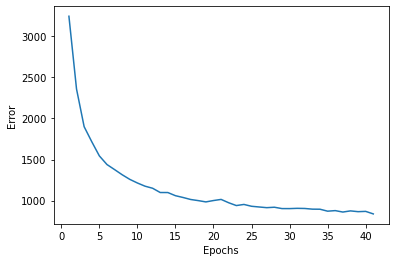

In [5]:
# import numpy as np
import cupy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- 각 설정값 --
img_size = 8
n_in_out = img_size*img_size
n_mid = 16

eta = 0.01
epochs = 41
batch_size = 32
interval = 4

# -- 훈련 데이터 생성 --
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 15

# -- 각 신경망층에서 상속할 입력층 --
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 은닉층 --
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # He의 초깃값
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <=0, 0, self.u)   # ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u<=0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 출력층 --
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # 시그모아드 함수
        
    def backward(self, t):
        delta = (self.y - t) * self.y * (1-self.y)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 각 신경층의 초기화 --
middle_layer = MiddleLayer(n_in_out, n_mid)  # 인코더
output_layer = OutputLayer(n_mid, n_in_out)  # 디코더

# -- 순전파 함수 --
def forward_propagation(x_mb):
    middle_layer.forward(x_mb)
    output_layer.forward(middle_layer.y)
    
# -- 역전파 함수 --
def backpropagation(t_mb):
    output_layer.backward(t_mb)
    middle_layer.backward(output_layer.grad_x)
    
# -- 파라미터 갱신 함수 --
def update_params():
    middle_layer.update(eta)
    output_layer.update(eta)
    
# -- 오차 계산 함수 --
def get_error(y,t):
    return 1.0/2.0*np.sum(np.square(y-t))    # 오차 제곱의 합

error_record = []
n_batch = len(x_train) // batch_size   # 1에포크당 배치 개수
for i in range(epochs):
    # -- 학습 --
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)     # 인덱스 뒤섞기(셔플하기)
    
    for j in range(n_batch):
        # 미니 배치 학습 실행
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        
        # 순전파와 역전파 함수 실핼
        forward_propagation(x_mb)
        backpropagation(x_mb)
        
        # 가중치와 편향 업데이트
        update_params()
        
    # -- 오차 계산 --
    forward_propagation(x_train)
    error = get_error(output_layer.y, x_train)
    error_record.append(error)
    
    # -- 결과 확인 --
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))
        
plt.plot(range(1, len(error_record)+1), np.asnumpy(np.asarray(error_record)))
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

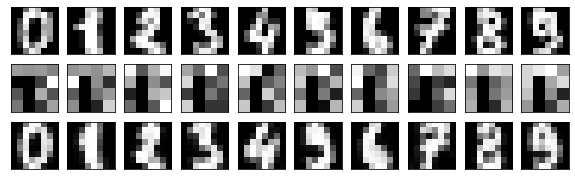

In [7]:
n_img = 10    # 보여줄 이미지 수
middle_layer.forward(x_train[:n_img])
output_layer.forward(middle_layer.y)

plt.figure(figsize=(10, 3))
for i in range(n_img):
    # 입력 이미지
    ax = plt.subplot(3, n_img, i+1)
    plt.imshow(x_train[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 은닉층에서 출력한 이미지
    ax = plt.subplot(3, n_img, i+1+n_img)
    plt.imshow(middle_layer.y[i].reshape(4, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 출력 이미지
    ax = plt.subplot(3, n_img, i+1+n_img*2)
    plt.imshow(output_layer.y[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()